# Resampling in the sinogram space

https://arxiv.org/pdf/1708.05163.pdf

https://github.com/tsiper/sampl-ct/blob/master/Interpolation/SinogramKernel.m

In [1041]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt

In [1042]:
"""
The functions of this cell are mostly copy pasted from their matlab code.
"""

def hamming_window(ts, thetas, window_size):
    t_grid, theta_grid = np.meshgrid(ts, thetas)
    r = np.sqrt(t_grid ** 2 + (theta_grid / np.pi) ** 2)
    w = np.zeros_like(r)
    w[r < window_size / 2] = 0.54 + 0.46 * np.cos(2 * np.pi * r[r < window_size / 2] / window_size)
    return w

def sinogram_kernel(ts, thetas, B, R, W):

    t_grid, theta_grid = np.meshgrid(ts, thetas)
    res = np.zeros_like(t_grid)

    def aux1(mask, t, theta):
        a = (np.cos(W * t - theta * (B + R * W)) - np.cos(B * theta)) / (t - theta * R)
        b = (np.cos(W * t + theta * (B + R * W)) - np.cos(B * theta)) / (t + theta * R)
        res[mask] = (a - b) / (np.pi * theta)

    def aux2(mask, theta):
        res[mask] = (2 * theta * R * W * np.sin(theta * B) + np.cos(theta * B) - np.cos(theta * (B + 2 * R * W))) / (2 * np.pi * R * theta**2)

    def aux3(mask, t):
        res[mask] = (2 * t * np.sin(W * t) * (B + R * W) + 2 * R * (np.cos(W * t) - 1)) / (np.pi * t**2)

    def aux4(mask):
        res[mask] = 2 / np.pi * W * (B + (R * W) / 2)

    mask1 = (theta_grid == 0)
    mask2 = (t_grid == 0)
    mask3 = (abs(t_grid) - abs(theta_grid * R)) == 0
    aux4(mask1 & mask2)
    aux3(mask1 & (~mask2), t_grid[mask1 & (~mask2)])
    aux2(~mask1 & mask3, theta_grid[~mask1 & mask3])
    aux1(~mask1 & ~mask3, t_grid[~mask1 & ~mask3], theta_grid[~mask1 & ~mask3])

    return res

def old_sinogram_kernel(ts, thetas, B, R, W):

    def aux(t, theta):

        if theta == 0:
            if t == 0:
                return 2 / np.pi * W * (B + (R * W) / 2)
            else:
                return (2 * t * np.sin(W * t) * (B + R * W) + 2 * R * (np.cos(W * t) - 1)) / (np.pi * t**2)
        
        elif abs(t) == abs(theta * R):
            return (2 * theta * R * W * np.sin(theta * B) + np.cos(theta * B) - np.cos(theta * (B + 2 * R * W))) / (2 * np.pi * R * theta**2)
        
        else:
            v1 = (np.cos(W * t - theta * (B + R * W)) - np.cos(B * theta)) / (t - theta * R)
            v2 = (np.cos(W * t + theta * (B + R * W)) - np.cos(B * theta)) / (t + theta * R)
            return (v1 - v2) / (np.pi * theta)


    a = np.zeros(shape=(len(thetas), len(ts)))

    for i, theta in enumerate(thetas):
        for j, t in enumerate(ts):
            a[i, j] = aux(t, theta)

    return a

# Test

In [1043]:
from silx.image.projection import Projection

from ppfft.tools.phantom_generator import generate_phantom
from ppfft.tools.grids import domain

In [1090]:
n = 1024
B = (2 * n + 2) // 8 
R = 1 / (np.sqrt(2) * np.pi)
W = np.pi * n
window_size = 8

ts = np.linspace(-0.5, 0.5, num=n)
thetas = np.linspace(-np.pi / 2, np.pi / 2, num=n)

h_full = sinogram_kernel(ts, thetas, B, R, W)
window = hamming_window(ts, thetas, 2 * window_size / n)
h_window = window * h_full
h_window /= np.sum(h_window)

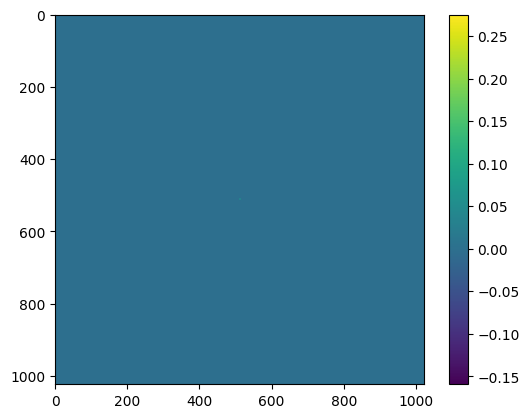

In [1091]:
plt.imshow(h_window)
plt.colorbar()

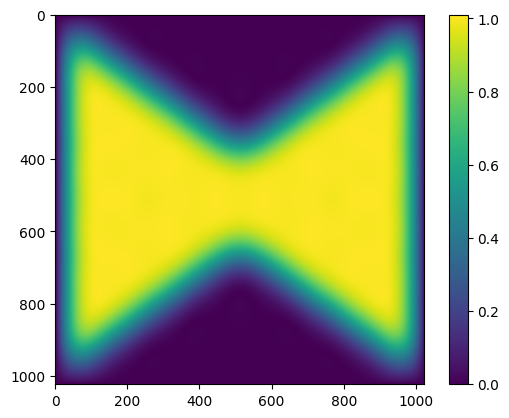

In [1092]:
plt.imshow(fft.fftshift(np.abs(fft.fft2(h_window))))
plt.colorbar()

In [1093]:
def compute_b(sinogram, q, reg=1e-6):
    fft2_sino = fft.fft2(sinogram)
    fft2_q = np.abs(fft.fft2(q))
    res = fft.ifft2(fft2_q * fft2_sino / (fft2_q ** 2 + reg))
    return res.real

In [1094]:
from scipy.signal import fftconvolve

In [1095]:
im = generate_phantom(n)
proj = Projection(im.shape, thetas)
sinogram = proj.projection(im)

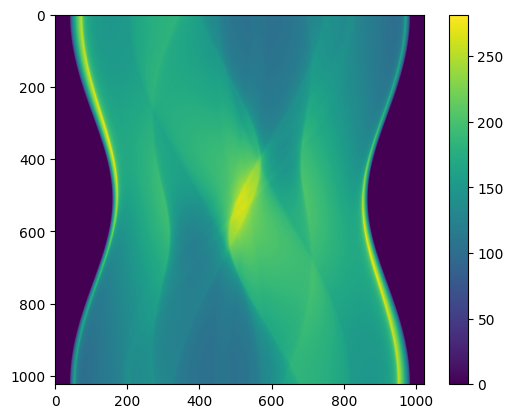

In [1096]:
plt.imshow(sinogram)
plt.colorbar()

In [1097]:
b = compute_b(sinogram, h_window, 1e-3)

In [1098]:
res = fftconvolve(b, h_window, mode='same')

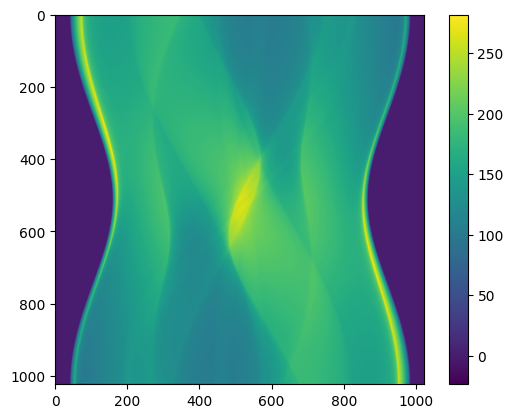

In [1099]:
plt.imshow(res)
plt.colorbar()

In [1054]:
from ppfft.ppfft.new_ppfft import new_ppfft

In [1055]:
n = 500
im = generate_phantom(n)

In [1056]:
hori, vert = new_ppfft(im)

In [1057]:
ifft_hori = fft.irfft(hori, axis=0)
ifft_vert = fft.irfft(vert, axis=0)

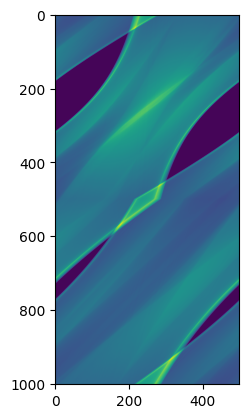

In [1058]:
sino_from_ppfft = np.concatenate((ifft_hori.T, ifft_vert[::-1, ::-1].T), axis=0)
plt.imshow(sino_from_ppfft)

It seems this is a sort of aliased Radon transform. This is coherent with the original paper on the PP transform, which oversampled the Fourier domain by a factor 2, to enable a Radon transform. However, it looks very different from what we are supposed to reproduce, so we don't think it will work with this convention for the PPFFT. We try going back to the old one.

# Original PPFFT and corresponding Radon transform

In [1059]:
from ppfft.tools.new_fft import new_fft, new_ifft
from ppfft.tools.pad import pad
from ppfft.tools.frac_fft import fast_frac_fft

In [1060]:
def old_ppfft_horizontal(im):
    n = im.shape[0]
    m = 2 * n + 1
    res = np.zeros(shape=(2 * n + 1, n + 1), dtype=complex) # k, l

    fft_col = new_fft(pad(im, new_shape=(n, m)), axis=-1)

    for k, col in zip(domain(m), fft_col.T):
        res[k + n, :] = fast_frac_fft(col, beta=-2 * k / (n * (2 * n + 1)), m=n + 1)
    return res

def old_ppfft_vertical(im):
    return old_ppfft_horizontal(im.T)

def old_ppfft(im):
    return old_ppfft_horizontal(im), old_ppfft_vertical(im)

In [1061]:
def old_radon_transform(im):
    """l = np.arange(-(n//2), n//2 + 1)
    Theta2 = np.arctan(2 * l / n) # from 3pi/4 to pi/4 (decreasing)
    Theta1 = np.pi / 2 - Theta2 # from -pi/4 to pi/4 (increasing)"""
    hori, vert = old_ppfft(im)
    fft_hori = new_ifft(hori, axis=0)
    fft_vert = new_ifft(vert, axis=0)

    return np.concatenate((fft_hori, fft_vert[::-1, ::-1]), axis=1).real

In [1062]:
n = 256
im = generate_phantom(n)

In [1063]:
old_radon = old_radon_transform(im)

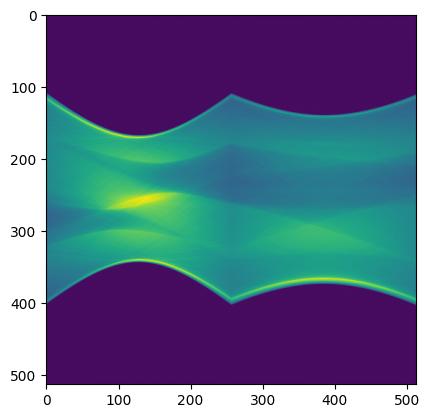

In [1064]:
plt.imshow(old_radon)

This uses the new definition, without $m = 2n + 1$.

In [1065]:
from ppfft.ppfft import ppfft

In [1066]:
def radon_transform(im):
    hori, vert = ppfft(im)
    fft_hori = new_ifft(hori, axis=0)
    fft_vert = new_ifft(vert, axis=0)

    return np.concatenate((fft_hori, fft_vert[::-1, ::-1]), axis=1).real

In [1067]:
radon = radon_transform(im)

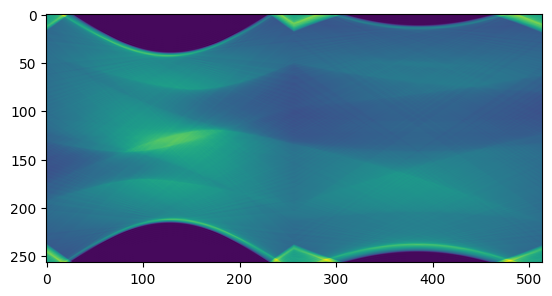

In [1068]:
plt.imshow(radon)

We can see that it looks the same, but some parts have been folded onto the real radon transform. We try to reproduce this:

In [1069]:
def radon_from_old_radon(old_radon):
    n = old_radon.shape[0] // 2 # old_radon.shape = (2 * n + 1, 2 * n + 2)
    
    res = np.copy(old_radon[n - n//2:n + n//2+1])
    res[:n//2] += old_radon[-(n//2):]
    res[-(n//2):] += old_radon[:n//2]

    return res

In [1070]:
old_radon = old_radon_transform(im)
radon = radon_transform(im)
res = radon_from_old_radon(old_radon)

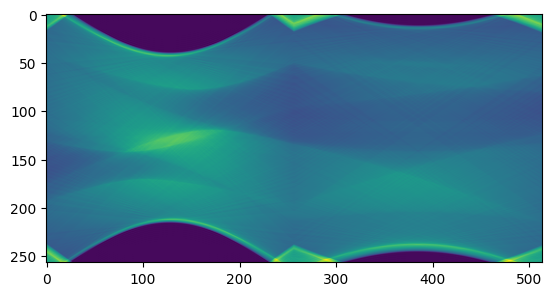

In [1071]:
plt.imshow(res)

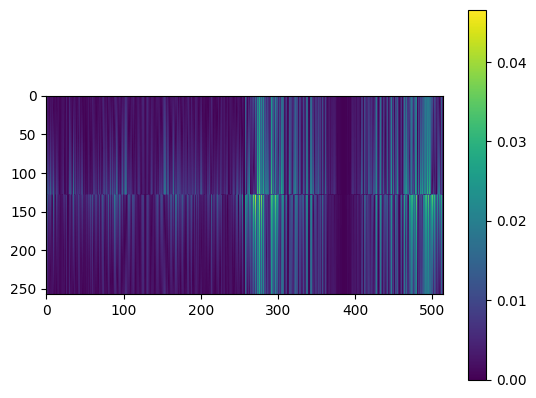

In [1072]:
plt.imshow(np.abs(res - radon))
plt.colorbar()

It seems to work.

```matlab
l = -N/2:N/2;
theta_pp = [atan(2*l/N),fliplr(pi/2-atan(2*l/N))]*180/pi;

%% Commencing Calculation
% Preallocation
ppSinogram  = zeros(2*N+1 , 2*N+2 );
[Mpp,Npp] = size(ppSinogram);


%% Commencing Calculation
% Preallocation
ppSinogram  = zeros(2*N+1 , 2*N+2 );
[Mpp,Npp] = size(ppSinogram);

% Running the interpolation steps
parfor l=1:Npp
    for k=1:Mpp

        if (theta_pp(l) >= -45) && (theta_pp(l) < 45)
            K = k-1-(Mpp)/2;
            T = abs(cosd(theta_pp(l)));
        else
            K = k-1-(Mpp+2*(theta_pp(l)-45)/45)/2;
            T = abs(sind(theta_pp(l)));
        end

        I =  (1:size(FiltSinogram,1)) - 1 - (size(FiltSinogram,1)+1)/2;
        d_theta = deg2rad( theta_pp(l)-theta );
        d_t     = (K*T-I)/size(FiltSinogram,1);
        
        % Another small correction found experimentally
        d_t = d_t - abs( mod(theta_pp(l)+45,90) - 45 )/180/size(FiltSinogram,1);
        
        %% Fast window design
        % Finding the correct range of points
        [~,min_theta_idx] = min(abs(d_theta));
        [~,min_t_idx    ] = min(abs(d_t));
        delta = ceil(WindowSize);

        % Iterating over all the relevant points with contribution
        i =  (-delta:delta) + min_t_idx;
        i((i<1)|(i>length(d_t))) = [];
        j =  (-delta:delta) + min_theta_idx;
        j((j<1)|(j>length(d_theta))) = [];
        
        % Building the window function
        [d_Theta,d_T] = meshgrid(d_theta(j),d_t(i));
        Rad = sqrt((d_T).^2+(d_Theta/pi).^2);
        Window = 0.54 + 0.46*cos(2*pi*Rad/WindowSize*N);
        Window(Rad>=(WindowSize/2/N)) = 0;
        
        % Computing the relevant kernel
        h = T*Window.*SinogramKernel(d_theta(j),d_t(i),B,R,W)/numel(FiltSinogram);

        % Performing the interpolation for a specific point
        ppSinogram(k,l) = vec(h)'*vec(FiltSinogram(i,j));

    end
```

In [1073]:
def interpolate_sino(thetas, window_size, b, n):
    """
    b is FiltSinogram
    """

    n_theta, n_r = b.shape

    l = np.arange(-(n//2), n//2 + 1)
    thetas_pp = np.concatenate((np.arctan(2 * l / n), np.pi / 2 - np.arctan(2 * l / n)[::-1]))

    pp_sinogram = np.zeros(shape=(2 * n + 2, 2 * n + 1)) # theta, r
    Mpp, Npp = 2 * n + 1, 2 * n + 2
    
    for l in range(Npp): # theta
        for k in range(Mpp): # r
            
            theta_pp = thetas_pp[l]

            if (theta_pp >= -np.pi / 4) and (theta_pp < np.pi / 4):
                K = k - 1 - Mpp / 2
                T = np.abs(np.cos(theta_pp))
            else:
                K = k - 1 - (Mpp + 2 * (theta_pp - np.pi / 4) / (np.pi / 4)) / 2
                T = np.abs(np.sin(theta_pp))

            I = np.arange(1, n_r + 1) - 1 - (n_r + 1) / 2
            d_theta = theta_pp - thetas
            d_t = (K * T - I) / n_r
            d_t -= abs(np.mod(theta_pp + np.pi / 4, np.pi / 2) - np.pi / 4) / (np.pi * n_r)

            min_theta_idx = np.argmin(np.abs(d_theta))
            min_t_idx = np.argmin(np.abs(d_t))
            delta = int(np.ceil(window_size))

            j = np.arange(-delta, delta + 1) + min_t_idx
            j = j[(j >= 0) & (j < len(d_t))]
            i = np.arange(-delta, delta + 1) + min_theta_idx
            i = i[(i >= 0) & (i < len(d_theta))]
            
            d_Theta, d_T = np.meshgrid(d_theta[i], d_t[j], indexing='ij')
            Rad = np.sqrt(d_T ** 2 + (d_Theta / np.pi) ** 2)
            Window = 0.54 + 0.46 * np.cos(2 * np.pi * Rad / window_size * n)
            Window[Rad >= window_size / (2 * n)] = 0

            h = T * Window * sinogram_kernel(d_t[j], d_theta[i], B, R, W) / np.size(b)

            pp_sinogram[l, k] = np.sum(h * b[np.ix_(i, j)])

    return pp_sinogram

In [1101]:
n = 128
B = (2 * n + 2) // 8 
R = 1 / (np.sqrt(2) * np.pi)
W = np.pi * n
window_size = 8

ts = np.linspace(-0.5, 0.5, num=n)
thetas = np.linspace(-np.pi / 2, np.pi / 2, num=n)

h_full = sinogram_kernel(ts, thetas, B, R, W)
window = hamming_window(ts, thetas, 2 * window_size / n)
h_window = window * h_full
h_window /= np.sum(h_window)

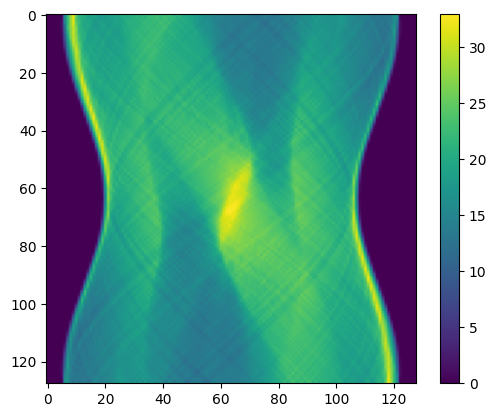

In [1102]:
im = generate_phantom(n)
proj = Projection(im.shape, thetas)
sinogram = proj.projection(im)
plt.imshow(sinogram)
plt.colorbar()

In [1103]:
b = compute_b(sinogram, h_window, 1e-3)

In [1104]:
pp_sino = interpolate_sino(thetas, window_size, b, n)

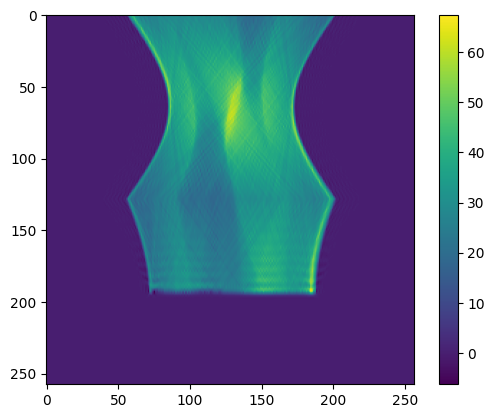

In [1105]:
plt.imshow(pp_sino)
plt.colorbar()